In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import os
import sys
import re

# customized packages
import dataset
import utils
from mlp import projector
from metricpref_learner import MetricPrefLearner

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils

In [20]:
def train(learner,optimizer,loss_fn,train_loader,test_loader,epochs,relative_error_ind=True, true_M=None, true_u=None):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
        'relative_ideal_point_error_record': [],
    }

    tqdmr = tqdm(range(epochs))
    for ep in tqdmr:
        for x,y in train_loader:
            # x[0] = x[0].to(device)
            # x[1][0] = x[1][0].to(device)
            # x[1][1] = x[1][1].to(device)
            # y = y.to(device)
            optimizer.zero_grad()
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            if relative_error_ind:
                # calculate the relative_metric_error
                L = learner.model.layers.weight
                relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
                train_stats['relative_metric_error_record'].append(relative_metric_error.item())
                # calculate the relative_ideal_point_error
                relative_ideal_point_error = (torch.norm(torch.tensor(true_u)-learner.us) / torch.norm(torch.tensor(true_u))).item()
                train_stats['relative_ideal_point_error_record'].append(relative_ideal_point_error)
            loss = loss_fn(pred_delta,y)
            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/len(y))
            loss.backward()
            optimizer.step()
        val_stat = val(learner,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
        tqdmr.set_postfix({'test_accu': val_stat['test_accu']})
    return train_stats

def val(learner,loss_fn,test_loader):
    total_val_samples = len(test_loader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }
    with torch.no_grad():
        for x,y in test_loader:
            # x[0] = x[0].to(device)
            # x[1][0] = x[1][0].to(device)
            # x[1][1] = x[1][1].to(device)
            # y = y.to(device)
            pred_delta = learner(x)
            acc_batch = torch.sum((pred_delta * y)>0)
            loss = loss_fn(pred_delta,y)

            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples

    return val_stat

class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]
    
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

def logistic(z):
    return 1 / (1 + torch.exp(-z))

def nll_logistic(predictions, targets):
    # Ensure targets are -1 or 1
    assert torch.all((targets == -1) | (targets == 1))
    
    probabilities = logistic(targets * predictions)
    # print(probabilities)
    nll = -torch.sum(torch.log(probabilities))
    # print(nll)
    return nll

# First Experiment
check the relative_metric_error and the relative_ideal_point error on the simulated dataset

(dataset hyperparameters are the same as the original paper)

In [21]:
########### hyperparameters for the dataset ################
feature_dim = 10
metric_rank = 1
num_items = 100
num_users = 10
num_pairs_per_user = 300

########### hyperparameters for the training ################
# Notice: these hyperparameters are chosen by the grid_search experiments
epochs = 2000
bs = 64
lr = 0.005
weight_decay_us = 0
weight_decay_net = 0.001
optimizer_name = 'adam'

############ normal dataset ################
# d: ambient dimension
# r: metric rank
# n: number of items
# N: number of users
# m: number of measurements per user
# noise_type: type of noise in measurement model, from {'none', 'logistic'}
# noise_param: noise parameter, if relevant (in 'logistic' noise, is noise scaling parameter)
# X: X: if None, generates new data. Else, specifies item matrix

pms = {'d': feature_dim, 
       'r': metric_rank, 
       'n': num_items,
       'N': num_users, 
       'm':1000,     # totally 1000 num_pairs_per_user
       'noise_type':'logistic', 
       'noise_param':1, 
       'X':None}

normal_dataset = dataset.Dataset(dataset_type='Normal', d=pms['d'], 
                                 r=pms['d'], n=pms['n'], 
                                 N=pms['N'], m=pms['m'], 
                                 noise_type=pms['noise_type'], 
                                 noise_param=pms['noise_param'], X=None)
normal_data = normal_dataset.getAllData()

items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=num_users*num_pairs_per_user)

############ define dataloader ################
train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

############ initialize the model and the learner################
net = projector(feature_dim=feature_dim, num_layer=1, num_class=feature_dim, bias_ind=False)
learner = MetricPrefLearner(dim_feature=feature_dim, num_users=num_users, items=items)
learner.assignModel(net)
us_params = []
net_params = []
for name, param in learner.named_parameters():
    if 'us' in name:
        us_params.append(param)
    else:
        net_params.append(param)

############ define loss and optimizer ################
weight_decay_dic = [
    {'params': us_params, 'weight_decay': weight_decay_us},
    {'params': net_params, 'weight_decay': weight_decay_net}
]

loss_fn = hinge_loss
if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(weight_decay_dic, lr=lr, betas=(0.9, 0.999), eps=1e-8)
elif optimizer_name == 'sgd':
    optimizer = torch.optim.SGD(weight_decay_dic, lr=lr, momentum=0.9)

train_stats = train(learner, optimizer, loss_fn, train_dataloader, test_dataloader, epochs, 
                    relative_error_ind=True, true_M=true_M, true_u=true_u)


100%|██████████| 2000/2000 [01:21<00:00, 24.57it/s, test_accu=0.812]


In [22]:
# Oracle prediction (just for verification) original version
delta_s = []
pred_ys = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
print('Oracle prediciton:', np.mean(pred_ys == true_y))

Oracle prediciton: 0.8295


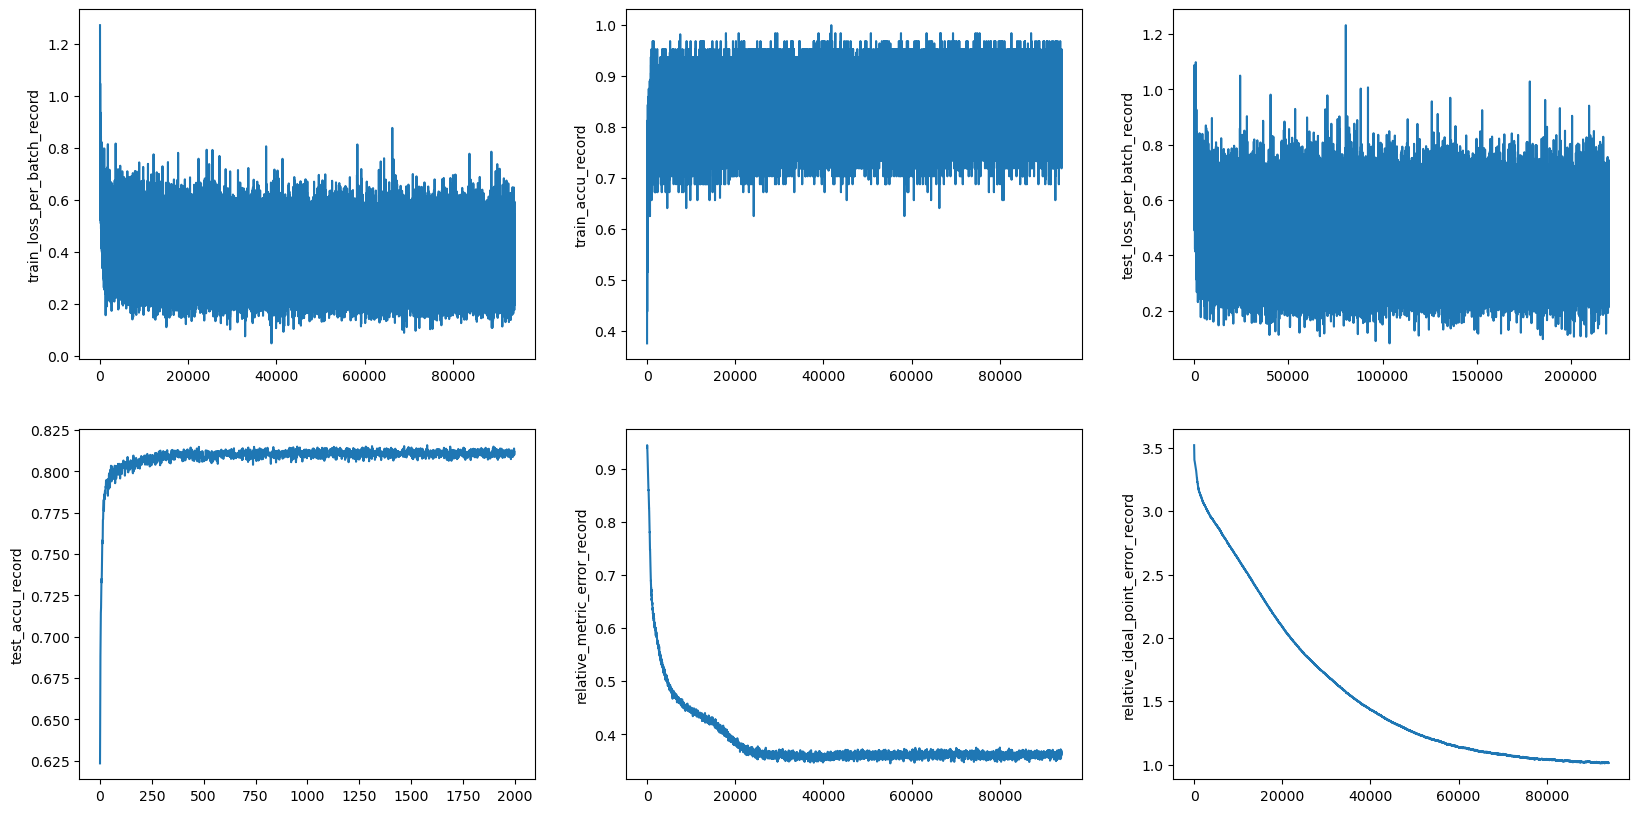

In [23]:
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax_flatten = ax.flatten()
for idx,key in enumerate(train_stats):
    ax_flatten[idx].plot(train_stats[key])
    ax_flatten[idx].set_ylabel(key)